<a href="https://colab.research.google.com/github/pantelisziazo/various_projects/blob/main/Named_Entity_Recognition_English_CONLL_2003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## In this script I apply Named Entity Recognition (NER) using a BERT-model over the [CoNLL-2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/). 

My purpose is to make a script that is *affordable to everyone* : runs quite fast, is easy to read and understandable. That is why I implemented it at Colab, utilizing GPU, added lots of comments and used methods of other people at the thought that they maybe more widely known). 

#### This dataset is **not** publicly available but anyone who wants to get access can follow the instrustions [here](https://www.clips.uantwerpen.be/conll2003/ner/000README) in order to get permission.

In the script that follows I drew ideas from :

*   [Named entity recognition with Bert](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/)
*   [Named Entity Recognition and Classification with Scikit-Learn](https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2)

For any question, please contact me through email at **larryziazo@gmail.com** .

# Build the appropriate environment and take a first look at the data. 

The use of GPU is strongly recommended. You can utilize **GPU** runtime **for free** at [Colab](https://colab.research.google.com/).

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, accuracy_score, classification_report 
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
!pip install transformers
import transformers
from transformers import BertForTokenClassification, AdamW, BertTokenizer, BertConfig, get_linear_schedule_with_warmup
from tqdm import tqdm, trange

In [2]:
# the names I am going to give at the columns of the dataset
column_names = ['words', 'pos', 'syntax', 'entity']
# the words are the x-variable of our problem
# the pos-tag and the syntax-chunk are additional information of each word
# the entity is the y-variable of our problem

# read the data
train = pd.read_csv('eng.train', sep=" ", names=column_names)
development = pd.read_csv('eng.testa', sep=" ", names = column_names)
test = pd.read_csv('eng.testb', sep=" ", names=column_names)

# the way the data was stored
train.head(5)

,words,pos,syntax,entity
0,-DOCSTART-,-X-,O,O
1,EU,NNP,I-NP,I-ORG
2,rejects,VBZ,I-VP,O
3,German,JJ,I-NP,I-MISC
4,call,NN,I-NP,O


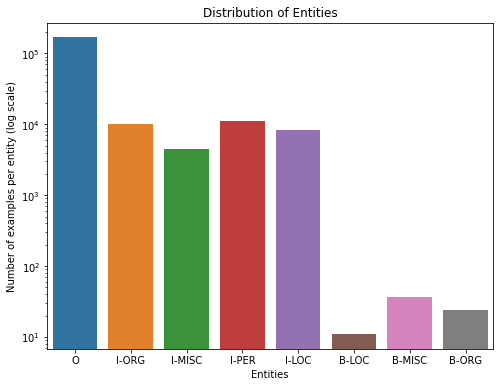

In [3]:
# take a look of the dataset
plt.figure(figsize=(8,6))
g = sns.countplot(x=train['entity'])
g.set_yscale('log')
plt.title('Distribution of Entities')
plt.xlabel('Entities')
plt.ylabel('Number of examples per entity (log scale)')
plt.show()
# similar information using pandas command (not so 'pretty' though) 
# train.groupby('entity').size().reset_index(name='counts')


#### The dataset is quite unbalanced. In order to get the better possible results there are some perspectives someone can follow :

1.   Apply undersampling over the training set only for the **{ O }** entity categoty. 
2.   Group together the corresponding **{ B- }** with **{ I- }** entity categories. 
3.   Leave the data as they are. 


At this project I will follow the easy path, the option (2) mentioned above. 

# Preprocess the data

In [4]:
def prepare_dataset(dataset):
  # drop the 1st row of the datasets since it is the header of the dataset
  dataset = dataset.drop([0])
  # drop the nan values 
  dataset = dataset.dropna()
  # the 1st column contains the words
  words = list(dataset['words'])
  # the 2nd column contains the part of speech tag (pos)
  pos = list(dataset['pos'])  
  # the 3rd column contains a syntactic chunk tag 
  syntax = list(dataset['syntax'])
  # the 4th column contains the entity labels
  entity = list(dataset['entity'])

  # omit the 'I-' and the 'B-' symbol in order to group by the corresponding categories
  for i in range(len(entity)):
    if len(entity[i]) > 1 : 
      entity[i] = entity[i][2:]
  
  # make list of sentences and the other variables
  sentence, sent_pos, sent_synt, sent_ent = [], [], [], []
  all_sent, all_pos, all_synt, all_ent = [], [], [], []
  for i in range(len(words)):
    # when a dot (.) is met that means that another sentence follows
    if words[i] == '.' :
      all_sent.append(sentence)
      sentence = []
      all_pos.append(sent_pos)
      sent_pos = []
      all_synt.append(sent_synt)
      sent_synt = []
      all_ent.append(sent_ent)
      sent_ent = []
    else:
      sentence.append(words[i])
      sent_pos.append(pos[i])
      sent_synt.append(syntax[i])
      sent_ent.append(entity[i])

  return all_sent, all_pos, all_synt, all_ent

train_sentences, train_pos, train_syntax, train_entity = prepare_dataset(train)
dev_sentences, dev_pos, dev_syntax, dev_entity = prepare_dataset(development)
test_sentences, test_pos, test_syntax, test_entity = prepare_dataset(test)

# take a look a the data now
print(train_sentences[0])
print(train_entity[0])
print()

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb']
['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O']



In [5]:
# get the name of the entities and add an additional 'PAD' entity since some sentences are going to be padded
all_entities = []
for i in train_entity:
  for j in i:
    all_entities.append(j)
    
tag_values = list(set(all_entities))
tag_values.append("PAD")

In [6]:
# also turn entities to numbers
tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)

{'MISC': 0, 'ORG': 1, 'PER': 2, 'O': 3, 'LOC': 4, 'PAD': 5}


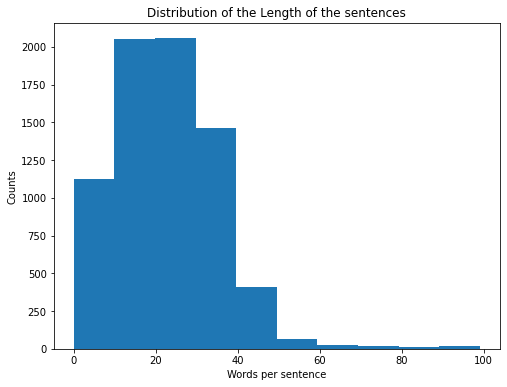

In [7]:
# Check the length of the sentences at train set in order to decide the max_length of the BERT model
sentence_len = []
for i in train_sentences:
  # there are a very few sentences with over 200 sentences
  if len(i) < 100: 
    sentence_len.append(len(i))
plt.figure(figsize=(8,6))
plt.hist(sentence_len)
plt.title('Distribution of the Length of the sentences')
plt.xlabel('Words per sentence')
plt.ylabel('Counts')
plt.show()

In [8]:
# 50 seems like a 'good' cutoff 
max_length = 50
batch_size = 64


# Prepare the data for the BERT 

In [9]:
# use of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

# download the BERT model for Named Entity Recognition
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# tokenize the sentences to words/subwords and keep the entities of all words and subwords
def tokenize_and_preserve_labels(sentence, text_labels):
  tokenized_sentence = []
  labels = []
  for word, label in zip(sentence, text_labels):
    # Tokenize each word
    tokenized_word = tokenizer.tokenize(word)
    # count the number of tokens/subwords the words is divided to
    n_subwords = len(tokenized_word)
    # Add the tokenized word to the final list
    tokenized_sentence.extend(tokenized_word)
    # Add the same entity label `n_subwords` times
    labels.extend([label] * n_subwords)    
  return tokenized_sentence, labels

# format the data in the way BERT needs them as input 
def get_x_y(x,y):
  tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(x, y)]
  # parse the sentences (the 'x' of the problem)
  sentences = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
  # pad the sentences
  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in sentences], maxlen=max_length, 
                          dtype="long", value=0.0,truncating="post", padding="post")

  # parse the labels (the 'y' of the problem)
  labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels] 
  # pad the labels
  tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels], maxlen=max_length,
                     value=tag2idx["PAD"], padding="post",dtype="long", truncating="post")
  # create the mask  
  attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

  return input_ids, tags, attention_masks

In [11]:
train_input, train_labels, train_masks = get_x_y(train_sentences, train_entity)
dev_input, dev_labels, dev_masks = get_x_y(dev_sentences, dev_entity)
test_input, test_labels, test_masks = get_x_y(test_sentences, test_entity)

# take a look how the data were 'converted' :
print("The 'x'-data looks like : ")
print("Before : ", train_sentences[0])
print("Now : ", train_input[0])
print()
print("The 'y'-data looks like : ")
print("Before : ", train_entity[0])
print("Now : ", train_labels[0])
print()
print("The mask of the above example looks like: ")
print(train_masks[0])

The 'x'-data looks like : 
Before :  ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb']
Now :  [ 7270 22961  1528  1840  1106 21423  1418  2495 12913     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]

The 'y'-data looks like : 
Before :  ['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O']
Now :  [1 3 0 3 3 3 0 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5]

The mask of the above example looks like: 
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
# convert the data to tensor and pass it to dataloaders 
def data_to_tensor_to_dataloader(x,mask,y, batch_size=batch_size):
  # to tensors
  xx = torch.tensor(x)
  yy = torch.tensor(y)
  mm = torch.tensor(mask)

  # to dataloader
  data = TensorDataset(xx, mm, yy)
  sampler = RandomSampler(data)
  dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
  return dataloader

train_dataloader = data_to_tensor_to_dataloader(train_input, train_masks, train_labels)
dev_dataloader = data_to_tensor_to_dataloader(dev_input, dev_masks, dev_labels)
test_dataloader = data_to_tensor_to_dataloader(test_input, test_masks, test_labels)

# Get the BERT ready

In [13]:
# the BERT model
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(tag2idx),
                                                   output_attentions = False, output_hidden_states = False)
model.cuda()

# parameters
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 3
max_grad_norm = 1.0
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,num_warmup_steps=0,num_training_steps=total_steps)


# Train the model

In [14]:
# almost the same as https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/
train_loss, acc, f1, val_loss, val_acc, val_f1 = [], [], [], [], [], []
for _ in trange(epochs, desc="Epoch"):
  model.train()
  # Reset the total loss for this epoch.
  total_loss = 0

  # Training loop
  for step, batch in enumerate(train_dataloader):
    # add batch to gpu
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    # Always clear any previously calculated gradients before performing a backward pass.
    model.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    # get the loss
    loss = outputs[0]
    # Perform a backward pass to calculate the gradients.
    loss.backward()
    # track train loss
    total_loss += loss.item()
    # Clip the norm of the gradient
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
    # update parameters
    optimizer.step()
    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over the training data.
  avg_train_loss = total_loss / len(train_dataloader)
  print()
  print("Average train loss: {}".format(avg_train_loss))
  # Store the loss value for plotting the learning curve.
  train_loss.append(avg_train_loss)

  # Put the model into evaluation mode
  model.eval()
  # Reset the validation loss for this epoch.
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  predictions , true_labels = [], []
  for batch in dev_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

  eval_loss = eval_loss / len(dev_dataloader)
  val_loss.append(eval_loss)
  # print("Validation loss: {}".format(eval_loss))
  
  pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
  valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    
  val_f1.append(f1_score(valid_tags, pred_tags, average='weighted'))
  val_acc.append(accuracy_score(pred_tags, valid_tags))
  # print("Validation Accuracy: {}".format(val_acc[-1]))
  # print("Validation F1-Score: {}".format(val_f1[-1]))
  print()



Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


Average train loss: 0.2689972001866534


Epoch:  33%|███▎      | 1/3 [01:59<03:58, 119.25s/it]



Average train loss: 0.06966753297581754


Epoch:  67%|██████▋   | 2/3 [03:59<01:59, 119.75s/it]



Average train loss: 0.04446693980295596


Epoch: 100%|██████████| 3/3 [05:59<00:00, 119.70s/it]

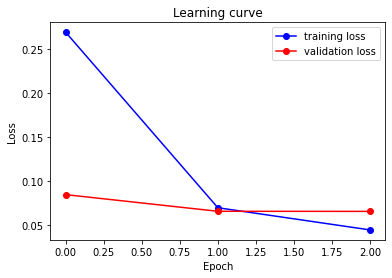

In [15]:
# Plot the learning curve.
plt.figure(figsize=(6,4))
plt.plot(train_loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Final scores

In [16]:
for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
  logits = outputs[0].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
  true_labels.extend(label_ids)


In [17]:
pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    
test_f1 = f1_score(valid_tags, pred_tags, average='weighted')
test_acc = accuracy_score(pred_tags, valid_tags)
print("Final Test Accuracy: {}".format(test_acc))
print("Final Test F1-Score: {}".format(test_f1))


Final Test Accuracy: 0.9760774485232689
Final Test F1-Score: 0.976120070585149


In [18]:
# classification report of the model 
pd.DataFrame(classification_report(pred_tags,valid_tags, output_dict=True))

,LOC,MISC,O,ORG,PER,accuracy,macro avg,weighted avg
precision,0.928547,0.806837,0.992228,0.889319,0.96711,0.976077,0.916808,0.976008
recall,0.925699,0.816047,0.993515,0.867913,0.96711,0.976077,0.914057,0.976077
f1-score,0.927121,0.811416,0.992871,0.878486,0.96711,0.976077,0.915401,0.976035
support,5868.000000,3066.000000,80183.000000,5027.000000,7601.00000,0.976077,101745.000000,101745.000000


# Get the entities of a sentence of your choice

In [22]:
# give the sentence of your choice
example = input("Write the sentence of your choice: \n")

Write the sentence of your choice: 
Ziazopoulos Pantelis is a person who works at NONE company, sends applications to data science companies and lives in Athens city, Greece.


In [23]:
def get_the_entities(example_sentence, tag_values=tag_values):
  tokenized_sentence = tokenizer.encode(example_sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
      new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
      new_labels.append(tag_values[label_idx])
      new_tokens.append(token)
  
  for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


In [24]:
get_the_entities(example)

O	[CLS]
PER	Ziazopoulos
PER	Pantelis
O	is
O	a
O	person
O	who
O	works
O	at
ORG	NONE
O	company
O	,
O	sends
O	applications
O	to
O	data
O	science
O	companies
O	and
O	lives
O	in
LOC	Athens
O	city
O	,
LOC	Greece
O	.
O	[SEP]


# Summary



In order to complete the task above I worked 9 hours, wanting to keep the workload at the levels of a single working day. 

The process I followed : 

1.   Asked permission for the data (**1st problem : I did not expect that the data would not be public**).
2.   Read various stuff regarding Named Entity Recognition (NER) over the internet. 
3.   Decided to build a BERT classifier since it is a pretrained model, giving excellent results at NER problems. **2nd problem** : I found it difficult to implement more basic algorithms, like a MLP, due to the format of the data and got confused about how to handle it. 
4.   Searched the internet again in order to find BERT algorithms that matched my purposes (easy to read, understable). **3rd problem** : I knew theoritical stuff regarding BERT models but I am not so good at writing code for the use of GPUs (make dataloaders, etc.). 
5.   Imlpemented all the stuff I found from the internet to my problem while trying to be as clear as possible. 

**Possible Future Work** :

*   Apply undersampling for the {O} class over the training set so that the classifier does not overfit at all at this entity category.
*   Do not group together the {B-} and the {I-} corresponding categories and check the scores of the model.  
*   Write more clear code for the training of the model and make more appealling visualization. 

---

I hope that you find this script quite readable and understandable.

